In [8]:
ls

data/       extract_utils.py  __pycache__/
extract.py  __init__.py       revisited_carotid_mini.ipynb


In [3]:
# parameters
DATASET="mutinfo_train_mini"
MODEL="dino_vits8"
MATRIX="laplacian"
DOWNSAMPLE=8
N_SEG=15
N_ERODE=2
N_DILATE=5

In [11]:
# extract features
!python extract.py extract_features \
    --images_list {"./data/"+DATASET+"/lists/images.txt"} \
    --images_root {"./data/"+DATASET+"/images"} \
    --output_dir {"./data/"+DATASET+"/features/"+MODEL} \
    --model_name {MODEL} \
    --batch_size 1

Using cache found in /home/guests/oleksandra_tmenova/.cache/torch/hub/facebookresearch_dino_main
Dataset size: 20
Dataloader size: 20
Processing: 100%|███████████████████████████████| 20/20 [00:03<00:00,  5.47it/s]
Saved features to ./data/mutinfo_train_mini/features/dino_vits8


In [13]:
# Extract eigenvectors of the Laplacian matrix of our features
!python extract.py extract_eigs \
    --images_root {"./data/"+DATASET+"/images"} \
    --features_dir {"./data/"+DATASET+"/features/"+MODEL} \
    --which_matrix "laplacian" \
    --output_dir {"./data/"+DATASET+"/eigs"} \
    --K {N_SEG}

{'K': 15, 'which_matrix': 'laplacian', 'which_features': 'k', 'which_color_matrix': 'knn', 'normalize': True, 'threshold_at_zero': True, 'images_root': './data/mutinfo_train_mini/images', 'output_dir': './data/mutinfo_train_mini/eigs', 'image_downsample_factor': None, 'image_color_lambda': 0.0, 'lapnorm': True, 'image_ssd_beta': 0.0}
  0%|                                                    | 0/20 [00:00<?, ?it/s]^C


(15, 1024)
(15, 32, 32)


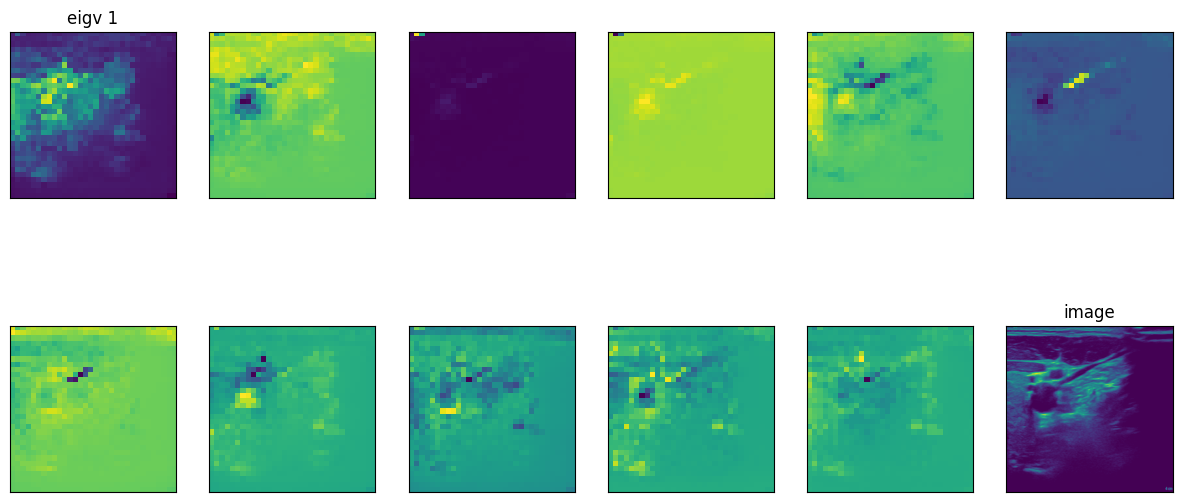

In [14]:
import torch
import numpy as np
from PIL import Image

dir="./data/"+DATASET+"/images/"
image_name="img0011"
image_path=dir+image_name+".jpg"
im = np.array(Image.open(image_path))
eigs_path="./data/"+DATASET+"/eigs/laplacian/"+image_name+".pth"
feat_path="./data/"+DATASET+"/features/dino_vits8/"+image_name+".pth"
data_dict = torch.load(feat_path, map_location='cpu')
data_dict.update(torch.load(eigs_path, map_location='cpu'))
eigenvectors = data_dict['eigenvectors'][:N_SEG].numpy()
print(eigenvectors.shape)

import extract_utils as utils
B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)

eigenvectors_img=eigenvectors.reshape(N_SEG, H_patch, W_patch)
print(eigenvectors_img.shape)


import matplotlib.pyplot as plt
# plt.axis('off')

fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(15, 7))
# fig.set_dpi(512)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12 = ax.flatten()
ax1.imshow(eigenvectors_img[1])
ax1.title.set_text("eigv 1")
ax2.imshow(eigenvectors_img[2])
ax3.imshow(eigenvectors_img[3])
ax4.imshow(eigenvectors_img[4])
ax5.imshow(eigenvectors_img[5])
ax6.imshow(eigenvectors_img[6])
ax7.imshow(eigenvectors_img[7])
ax8.imshow(eigenvectors_img[8])
ax9.imshow(eigenvectors_img[9])
ax10.imshow(eigenvectors_img[10])
# ax11.imshow(im)
# ax11.title.set_text("image")
ax11.imshow(eigenvectors_img[11])
ax12.imshow(im)
ax12.title.set_text("image")
# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
plt.show()

In [15]:
# (1) Extract segments
!python extract.py extract_multi_region_segmentations \
    --features_dir {"./data/"+DATASET+"/features/"+MODEL} \
    --eigs_dir {"./data/"+DATASET+"/eigs/"+MATRIX} \
    --output_dir {"./data/"+DATASET+"/multi_region_segmentation/"+MATRIX} \
    --adaptive False \
    --non_adaptive_num_segments {N_SEG} \

100%|███████████████████████████████████████████| 20/20 [01:00<00:00,  3.00s/it]
Finished in 60.1s


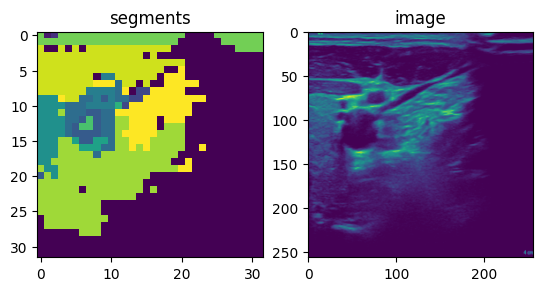

In [16]:
# visualisation
dir="./data/"+DATASET+"/multi_region_segmentation/"+MATRIX+"/"
segm_path=dir+image_name+".png"
segm = np.array(Image.open(segm_path))

fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()

ax1.imshow(segm)
ax1.title.set_text("segments")
ax2.imshow(im)
ax2.title.set_text("image")

plt.show()

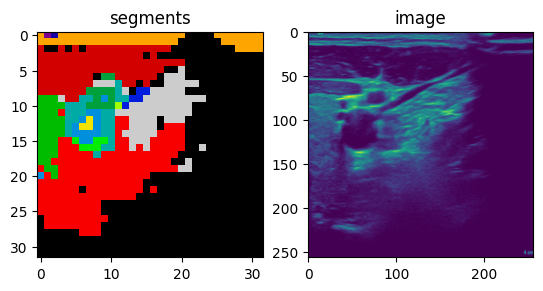

In [17]:
# imporivng different segments visibility
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()

ax1.imshow(segm, cmap="nipy_spectral")
ax1.title.set_text("segments")
ax2.imshow(im, cmap="viridis")
ax2.title.set_text("image")
plt.show()

In [18]:
# (2) Extract bounding boxes
!python extract.py extract_bboxes \
    --features_dir {"./data/"+DATASET+"/features/"+MODEL} \
    --segmentations_dir {"./data/"+DATASET+"/multi_region_segmentation/"+MATRIX} \
    --num_erode {N_ERODE} \
    --num_dilate {N_DILATE} \
    --downsample_factor {DOWNSAMPLE} \
    --output_file {"./data/"+DATASET+"/multi_region_bboxes/"+MATRIX+"/bboxes.pth"}

Extracting bounding boxes: 100%|████████████████| 20/20 [00:00<00:00, 71.82it/s]
Done


In [19]:
# (3) Extract bounding box features
!python extract.py extract_bbox_features \
    --model_name {MODEL} \
    --images_root {"./data/"+DATASET+"/images"} \
    --bbox_file {"./data/"+DATASET+"/multi_region_bboxes/"+MATRIX+"/bboxes.pth"} \
    --output_file {"./data/"+DATASET+"/multi_region_bboxes/"+MATRIX+"/bbox_features.pth"}

Loaded bounding box list. There are 280 total bounding boxes.
Using cache found in /home/guests/oleksandra_tmenova/.cache/torch/hub/facebookresearch_dino_main
100%|███████████████████████████████████████████| 20/20 [06:37<00:00, 19.85s/it]
Saved features to ./data/mutinfo_train_mini/multi_region_bboxes/laplacian/bbox_features.pth


In [20]:
# (4) Extract clusters
!python extract.py extract_bbox_clusters \
    --bbox_features_file {"./data/"+DATASET+"/multi_region_bboxes/"+MATRIX+"/bbox_features.pth"} \
    --output_file {"./data/"+DATASET+"/multi_region_bboxes/"+MATRIX+"/bbox_clusters.pth"} \
    --num_clusters {N_SEG}

Loaded bounding box list. There are 280 total bounding boxes with features.
Stacking and normalizing features
Computing K-Means clustering with 15 clusters
Cluster indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Cluster counts: [28, 37, 29, 10, 21, 15, 20, 14, 13, 8, 10, 13, 30, 18, 14]
Saved features to ./data/mutinfo_train_mini/multi_region_bboxes/laplacian/bbox_clusters.pth


In [21]:
# (5) Create semantic segmentations
!python extract.py extract_semantic_segmentations \
    --segmentations_dir {"./data/"+DATASET+"/multi_region_segmentation/"+MATRIX} \
    --bbox_clusters_file {"./data/"+DATASET+"/multi_region_bboxes/"+MATRIX+"/bbox_clusters.pth"} \
    --output_dir {"./data/"+DATASET+"/semantic_segmentations/patches/"+MATRIX+"/segmaps"}

Loaded bounding box list. There are 280 total bounding boxes with features and clusters.
100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1020.97it/s]
Saved features to ./data/mutinfo_train_mini/semantic_segmentations/patches/laplacian/segmaps


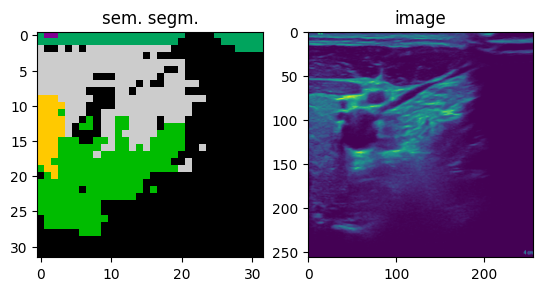

In [22]:
# visualize semantic segmentation
semseg_path="./data/"+DATASET+"/semantic_segmentations/patches/"+MATRIX+"/segmaps/"
semseg_im_path=semseg_path+image_name+".png"
semsegm_im = np.array(Image.open(semseg_im_path))
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()

ax1.imshow(semsegm_im, cmap="nipy_spectral")
ax1.title.set_text("sem. segm.")
ax2.imshow(im)
ax2.title.set_text("image")

plt.show()